In [ ]:
!pip install transformers

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.layers import Dense, Input, LSTM, Conv1D, MaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import re
import pickle
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [5]:
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased", cache_dir='bert_ckpt', do_lower_case=False)   # 사전학습 된 사전을 읽어온다
word2idx = tokenizer.vocab
idx2word = {v:k for k, v in word2idx.items()}

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

C:\Users\jaehy\anaconda3\lib\site-packages\huggingface_hub\file_download.py:123: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\jaehy\Desktop\github\Machine-Learning\NLP\bert_ckpt. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [ ]:
# print(idx2word)

In [6]:
# 작동 테스트
enc = tokenizer.encode('I love you'.split())
print(enc)
print([idx2word[x] for x in enc])

dec = tokenizer.decode(enc)
print(dec)

[101, 146, 16138, 13028, 102]
['[CLS]', 'I', 'love', 'you', '[SEP]']
[CLS] I love you [SEP]


In [7]:
# 한국어 테스트
sentence = '어릴때보고 지금다시봐도 재밌어요ㅋㅋ'
enc = tokenizer.encode(sentence.split())
print(enc)
print([idx2word[x] for x in enc])

dec = tokenizer.decode(enc)
print(dec)

[101, 100, 100, 100, 102]
['[CLS]', '[UNK]', '[UNK]', '[UNK]', '[SEP]']
[CLS] [UNK] [UNK] [UNK] [SEP]


In [12]:
# DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/data/'
DATA_PATH = ''
df = pd.read_csv(DATA_PATH + 'naver_movie/ratings.txt', header=0, delimiter='\t', quoting=3)
df = df.dropna()
df.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [13]:
# 간단한 전처리. 한글이 아닌 숫자, 영문자, 기호 등은 공백문자로 치환.
df['document'] = df['document'].apply(lambda x: re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\s]", " ", x))

document = list(df['document'])
label = list(df['label'])
x_train, x_test, y_train, y_test = train_test_split(document, label, test_size=0.2)

In [14]:
# MAX_LEN를 정하기 위해 기술통계량 확인
df['document'].apply(len).describe()

count    199992.000000
mean         35.233459
std          29.561006
min           1.000000
25%          16.000000
50%          27.000000
75%          42.000000
max         146.000000
Name: document, dtype: float64

In [15]:
MAX_LEN = 60

# Bert Tokenizer
def bert_tokenizer(sent):
    
    encoded_dict = tokenizer.encode_plus(
        text = sent,
        add_special_tokens = True,      # Add '[CLS]' and '[SEP]'
        max_length = MAX_LEN,           # Pad & truncate all sentences.
        padding = 'max_length',
        pad_to_max_length = True,
        return_attention_mask = True,   # Construct attn. masks.
        truncation = True
    )
    
    input_id = encoded_dict['input_ids']
    attention_mask = encoded_dict['attention_mask'] # And its attention mask (simply differentiates padding from non-padding).
    token_type_id = encoded_dict['token_type_ids']  # differentiate two sentences
    
    return input_id, attention_mask, token_type_id

In [16]:
text = document[0]
id, mask, typ = bert_tokenizer(text)
print(text)
print(id)
print(mask)
print(typ)

어릴때보고 지금다시봐도 재밌어요ㅋㅋ
[101, 9546, 85836, 118832, 30005, 11664, 9706, 40032, 11903, 14040, 118990, 12092, 100, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [17]:
text_1 = [idx2word[x] for x in id]
print(text_1)

['[CLS]', '어', '##릴', '##때', '##보', '##고', '지', '##금', '##다', '##시', '##봐', '##도', '[UNK]', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [18]:
# 문장 복원
print((' '.join(text_1)).replace(' ##', ''))  # 원리
print(tokenizer.decode(id))

print('토큰 길이 =', len(id))

[CLS] 어릴때보고 지금다시봐도 [UNK] [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
[CLS] 어릴때보고 지금다시봐도 [UNK] [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
토큰 길이 = 60


In [19]:
def build_data(doc):
    x_ids = []
    x_msk = []
    x_typ = []

    for sent in tqdm(doc, total=len(doc)):
        input_id, attention_mask, token_type_id = bert_tokenizer(sent)
        x_ids.append(input_id)
        x_msk.append(attention_mask)
        x_typ.append(token_type_id)

    x_ids = np.array(x_ids, dtype=int)
    x_msk = np.array(x_msk, dtype=int)
    x_typ = np.array(x_typ, dtype=int)

    return x_ids, x_msk, x_typ

In [20]:
x_train_ids, x_train_msk, x_train_typ = build_data(x_train)
x_test_ids, x_test_msk, x_test_typ = build_data(x_test)

y_train = np.array(y_train).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)

x_train_ids.shape, y_train.shape
x_test_ids.shape, y_test.shape

  0%|          | 0/159993 [00:00<?, ?it/s]

  0%|          | 0/39999 [00:00<?, ?it/s]

((39999, 60), (39999, 1))

In [21]:
bert_model = TFBertModel.from_pretrained("bert-base-multilingual-cased", cache_dir='bert_ckpt')
bert_model.summary() # bert_model을 확인한다. trainable params = 177,854,978

Downloading:   0%|          | 0.00/1.08G [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  177853440 
                                                                 
Total params: 177,853,440
Trainable params: 177,853,440
Non-trainable params: 0
_________________________________________________________________


In [22]:
# 시간이 오래 걸리므로 bert_model의 fine-tuning을 잠시 막아 놓자.
# downstream task 학습을 위해 bert_model도 fine-tuning해야 한다.
# 특정모델을 학습시키지 않을때
bert_model.trainable = False
bert_model.summary() # bert_model을 다시 확인한다. trainable params = 0

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  177853440 
                                                                 
Total params: 177,853,440
Trainable params: 0
Non-trainable params: 177,853,440
_________________________________________________________________


In [44]:
# BERT 입력
# ---------
x_input_ids = Input(batch_shape = (None, MAX_LEN), dtype = tf.int32)
x_input_msk = Input(batch_shape = (None, MAX_LEN), dtype = tf.int32)
x_input_typ = Input(batch_shape = (None, MAX_LEN), dtype = tf.int32)

# BERT 출력
# [0]: (None, 60, 768) - sequence_output, [1]: (None, 768) - pooled_output
# ------------------------------------------------------------------------
# output_bert = bert_model([x_input_ids, x_input_msk, x_input_typ])[0]
output_bert = bert_model([x_input_ids, x_input_msk, x_input_typ])[1]

# Downstream task : 네이버 영화 감성분석
# -------------------------------------
y_output = Dense(1, activation = 'sigmoid')(output_bert)
model = Model([x_input_ids, x_input_msk, x_input_typ], y_output)
model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 0.01))
model.summary()

# CNN 이용
# y_cnn = Conv1D(filters=32 , kernel_size=12, strides=2, activation='relu')(output_bert)
# y_maxpool = MaxPool1D(pool_size= 12, strides=2)(y_cnn)
# y_output = Dense(1, activation='sigmoid')(y_maxpool)
# model = Model([x_input_ids, x_input_msk, x_input_typ], y_output)
# model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 0.01))
# model.summary()

# LSTM 이용
# y_lstm = LSTM(128)(y_output)
# y_output = Dense(64, activation='sigmoid')(y_lstm)
# model = Model([x_input_ids, x_input_msk, x_input_typ], y_lstm)
# model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 0.01))
# model.summary

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  177853440   ['input_7[0][0]',                
                                thPoolingAndCrossAt               'input_8[0][0]',          

In [45]:
x_train = [x_train_ids, x_train_msk, x_train_typ]
x_test = [x_test_ids, x_test_msk, x_test_typ]
hist = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs=3, batch_size=1024)

Epoch 1/3
157/157 [==============================] - 602s 4s/step - loss: 0.6550 - val_loss: 0.6358
Epoch 2/3
157/157 [==============================] - 602s 4s/step - loss: 0.6311 - val_loss: 0.6091
Epoch 3/3
157/157 [==============================] - 601s 4s/step - loss: 0.6249 - val_loss: 0.6036


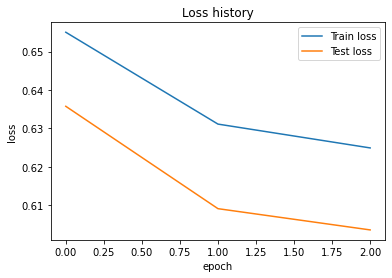

In [46]:
# Loss history를 그린다
plt.plot(hist.history['loss'], label='Train loss')
plt.plot(hist.history['val_loss'], label = 'Test loss')
plt.legend()
plt.title("Loss history")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [47]:
# 시험 데이터로 학습 성능을 평가한다
pred = model.predict(x_test)
y_pred = np.where(pred > 0.5, 1, 0)
accuracy = (y_pred == y_test).mean()
print("\nAccuracy = %.2f %s" % (accuracy * 100, '%'))

1250/1250 [==============================] - 168s 131ms/step

Accuracy = 67.78 %


# 한글로 만든 KoBERT

In [ ]:
!pip install transformers

# BERT를 이용한 네이버 영화 감성분석
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.train import latest_checkpoint
import re
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import os

# DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/data/'
DATA_PATH = ''

# DATA_PATH 아래 kykim_bert 폴더를 만들어 놓는다.
ckpt_path = DATA_PATH + 'kykim_bert/weights.h5'
ckpt_dir = DATA_PATH + 'kykim_bert'

# huggingface.co --> (우측상단) models --> (왼쪽 메뉴) languages에서 ko --> (오른쪽) kykim/bert-kor-base 클릭
tokenizer = BertTokenizer.from_pretrained("kykim/bert-kor-base", 
                                          cache_dir = 'kykim_bert_ckpt', 
                                          do_lower_case=False)
word2idx = tokenizer.vocab
idx2word = {v:k for k, v in word2idx.items()}

df = pd.read_csv(DATA_PATH + 'naver_movie/ratings.txt', header=0, delimiter='\t', quoting=3)[:10]
df = df.dropna()

# 간단한 전처리. 한글이 아닌 숫자, 영문자, 기호 등은 공백문자로 치환.
df['document'] = df['document'].apply(lambda x: re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\s]", " ", x))
df.drop('id', axis = 1, inplace = True)

document = list(df['document'])
label = list(df['label'])
x_train, x_test, y_train, y_test = train_test_split(document, label, test_size=0.2)

MAX_LEN = 60

# Bert Tokenizer
def bert_tokenizer(sent):
    
    encoded_dict = tokenizer.encode_plus(
        text = sent,
        add_special_tokens = True,      # Add '[CLS]' and '[SEP]'
        max_length = MAX_LEN,           # Pad & truncate all sentences.
        padding = 'max_length',
        # pad_to_max_length = True,
        return_attention_mask = True,   # Construct attn. masks.
        truncation = True
    )
    
    input_id = encoded_dict['input_ids']
    attention_mask = encoded_dict['attention_mask'] # And its attention mask (simply differentiates padding from non-padding).
    token_type_id = encoded_dict['token_type_ids']  # differentiate two sentences
    
    return input_id, attention_mask, token_type_id

text = document[1]
id, mask, typ = bert_tokenizer(text)
print(text)
print(id)
print(mask)
print(typ)

text_1 = [idx2word[x] for x in id]
print(text_1)

# 문장 복원
print((' '.join(text_1)).replace(' ##', ''))  # 원리
print(tokenizer.decode(id))

print('토큰 길이 =', len(id))

def build_data(doc):
    x_ids = []
    x_msk = []
    x_typ = []

    for sent in tqdm(doc):
        input_id, attention_mask, token_type_id = bert_tokenizer(sent)
        x_ids.append(input_id)
        x_msk.append(attention_mask)
        x_typ.append(token_type_id)

    x_ids = np.array(x_ids, dtype=int)
    x_msk = np.array(x_msk, dtype=int)
    x_typ = np.array(x_typ, dtype=int)

    return x_ids, x_msk, x_typ

x_train_ids, x_train_msk, x_train_typ = build_data(x_train)
x_test_ids, x_test_msk, x_test_typ = build_data(x_test)

y_train = np.array(y_train).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)

x_train_ids.shape, y_train.shape
x_test_ids.shape, y_test.shape

bert_model = TFBertModel.from_pretrained("kykim/bert-kor-base", cache_dir = 'kykim_bert_ckpt')
bert_model.summary() # bert_model을 확인한다. trainable params = 177,854,978

# 시간이 오래 걸리므로 bert_modeㅁl의 fine-tuning을 잠시 막아 놓자.
# downstream task 학습을 위해 bert_model도 fine-tuning해야 한다.
bert_model.trainable = True
bert_model.summary() # bert_model을 다시 확인한다. trainable params = 0

# BERT 입력
# ---------
x_input_ids = Input(batch_shape = (None, MAX_LEN), dtype = tf.int32)
x_input_msk = Input(batch_shape = (None, MAX_LEN), dtype = tf.int32)
x_input_typ = Input(batch_shape = (None, MAX_LEN), dtype = tf.int32)

# BERT 출력
# ---------
output_bert = bert_model([x_input_ids, x_input_msk, x_input_typ])[1]

# Downstream task : 네이버 영화 감성분석
# -------------------------------------
y_output = Dense(1, activation = 'sigmoid')(output_bert)
model = Model([x_input_ids, x_input_msk, x_input_typ], y_output)
model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 0.01))
model.summary()

if os.path.exists(ckpt_path):
    model.load_weights(ckpt_path)
    print('학습된 weight가 적용됐습니다.')

# Create a callback that saves the model's weights, every epochs
cp_callback = ModelCheckpoint(filepath=ckpt_path, 
                              save_weights_only=True, 
                              verbose=1,
                              save_freq=1)

x_train = [x_train_ids, x_train_msk, x_train_typ]
x_test = [x_test_ids, x_test_msk, x_test_typ]
hist = model.fit(x_train, y_train, 
                 validation_data = (x_test, y_test), 
                 epochs=3, 
                 batch_size=1024,
                 callbacks=[cp_callback])

# Loss history를 그린다
plt.plot(hist.history['loss'], label='Train loss')
plt.plot(hist.history['val_loss'], label = 'Test loss')
plt.legend()
plt.title("Loss history")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

# 시험 데이터로 학습 성능을 평가한다
pred = model.predict(x_test)
y_pred = np.where(pred > 0.5, 1, 0)
accuracy = (y_pred == y_test).mean()
print("\nAccuracy = %.2f %s" % (accuracy * 100, '%'))
